In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **CREDIT CARD FRAUD DETECTION**

# **Introduction**

Credit card fraud has become a significant threat in today’s digital economy, where millions of financial transactions are processed every minute. As consumers increasingly rely on online payments and e-commerce, financial institutions must ensure secure and trustworthy transaction environments. Detecting fraudulent activity early not only prevents financial losses but also protects customer trust and brand integrity. Given the massive volume and complexity of transaction data, machine learning offers a scalable and effective solution to identify suspicious patterns that may signal fraudulent behavior.

# **Problem statement**

The primary challenge in credit card fraud detection lies in identifying rare fraudulent transactions from a large number of legitimate ones. The dataset is highly imbalanced, where fraudulent cases represent a tiny fraction of all transactions. Moreover, fraud patterns constantly evolve, making rule-based systems insufficient. This project aims to develop a robust machine learning model capable of detecting fraudulent credit card transactions with high recall, while minimizing false positives. The solution should be interpretable, scalable, and suitable for integration into real-time fraud detection systems.

# **Data**

The data is sourced from Kaggle : https://www.kaggle.com/datasets/tjverry/credit-card-transactions

This dataset contains anonymized credit card transactions made by cardholders over a six-month period. Each row represents a unique transaction and includes fields such as customer_id, timestamp, amount, category, merchant, and city. The category field describes the type of purchase (e.g., groceries, entertainment), while the amount indicates the value of the transaction. Timestamp captures the exact date and time of the transaction, enabling temporal analysis. This dataset is suitable for use in behavioral modeling, spending pattern analysis, and fraud detection tasks, offering a comprehensive view of individual and aggregate cardholder activity.

**Import and Setup**

In [59]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import re
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
import joblib, time, os
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
import joblib, os, time
import numpy as np

In [60]:
# Replace 'your_file.csv' with the path to your CSV file
df = pd.read_csv('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/capstone-1/data/transactions.csv')

# **Data set overview**

In [61]:
# Display the first few rows
print(df.head())

# Check the shape of the dataset
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

   accountNumber  creditLimit  availableMoney  transactionDateTime  \
0      737265056         5000          5000.0  2016-08-13T14:27:32   
1      737265056         5000          5000.0  2016-10-11T05:05:54   
2      737265056         5000          5000.0  2016-11-08T09:18:39   
3      737265056         5000          5000.0  2016-12-10T02:14:50   
4      830329091         5000          5000.0  2016-03-24T21:04:46   

          merchantName  transactionAmount acqCountry merchantCountryCode  \
0                 Uber              98.55         US                  US   
1          AMC #191138              74.51         US                  US   
2           Play Store               7.47         US                  US   
3           Play Store               7.47         US                  US   
4  Tim Hortons #947751              71.18         US                  US   

   posEntryMode  posConditionCode  ... accountOpenDate  \
0           2.0               1.0  ...       3/14/2015   
1     

# **Feature Type**

In [62]:
# Separate features by data type
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

Categorical features: Index(['transactionDateTime', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'merchantCategoryCode', 'currentExpDate',
       'accountOpenDate', 'dateOfLastAddressChange', 'transactionType'],
      dtype='object')
Numerical features: Index(['accountNumber', 'creditLimit', 'availableMoney', 'transactionAmount',
       'posEntryMode', 'posConditionCode', 'cardCVV', 'enteredCVV',
       'cardLast4Digits', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')


# **Statistical Summary**

In [63]:
# Summary statistics
print(df[numerical_features].describe())

       accountNumber    creditLimit  availableMoney  transactionAmount  \
count   7.863630e+05  786363.000000   786363.000000      786363.000000   
mean    5.372326e+08   10759.464459     6250.725369         136.985791   
std     2.554211e+08   11636.174890     8880.783989         147.725569   
min     1.000881e+08     250.000000    -1005.630000           0.000000   
25%     3.301333e+08    5000.000000     1077.420000          33.650000   
50%     5.074561e+08    7500.000000     3184.860000          87.900000   
75%     7.676200e+08   15000.000000     7500.000000         191.480000   
max     9.993896e+08   50000.000000    50000.000000        2011.540000   

        posEntryMode  posConditionCode        cardCVV     enteredCVV  \
count  782309.000000     785954.000000  786363.000000  786363.000000   
mean        9.049943          3.271980     544.467338     544.183857   
std        16.774130          9.809023     261.524220     261.551254   
min         2.000000          1.000000     10

# **Exporatory Data Analysis**

**Class distribution**

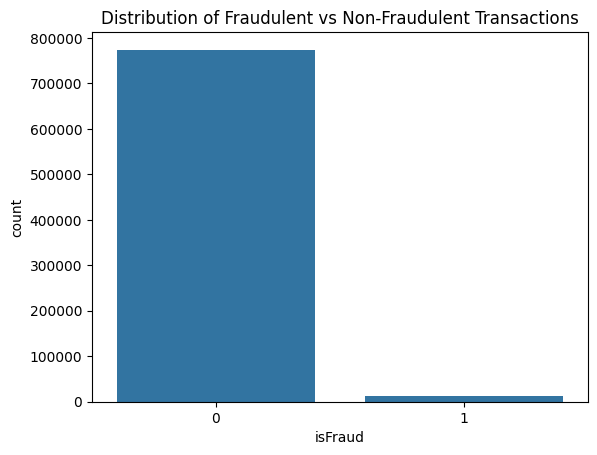

isFraud
0    773946
1     12417
Name: count, dtype: int64
isFraud
0    98.420958
1     1.579042
Name: count, dtype: float64


In [64]:
# Plot the distribution of the target variable
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

# Display the count and percentage
fraud_counts = df['isFraud'].value_counts()
print(fraud_counts)
print(fraud_counts / len(df) * 100)

**Correlation Analysis**

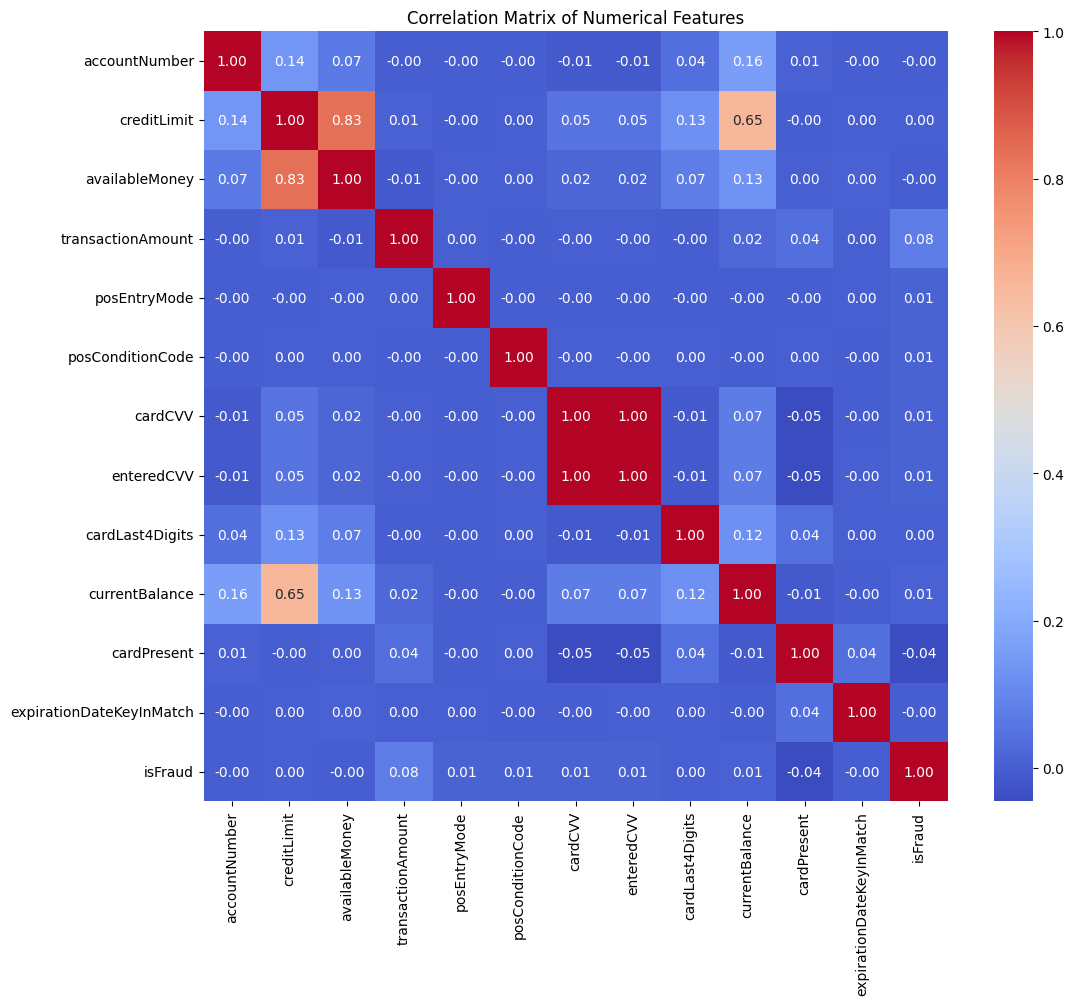

In [65]:
# Compute correlation matrix
corr_matrix = df[numerical_features].corr()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

**Transaction Amount Distribution by Fraud Status**

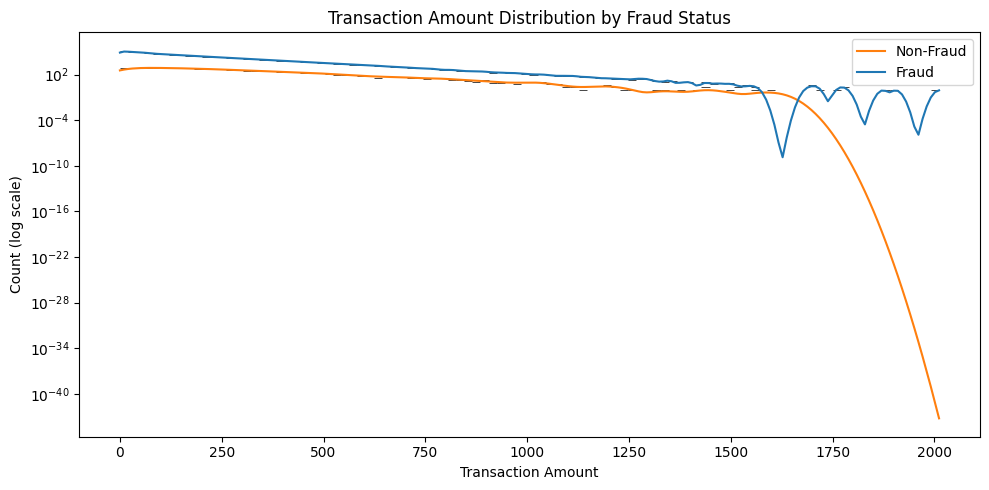

(isFraud
 0    773946
 1     12417
 Name: count, dtype: int64,
 np.float64(0.01579041740264992),
        accountNumber    creditLimit  availableMoney  \
 count   7.863630e+05  786363.000000   786363.000000   
 mean    5.372326e+08   10759.464459     6250.725369   
 min     1.000881e+08     250.000000    -1005.630000   
 25%     3.301333e+08    5000.000000     1077.420000   
 50%     5.074561e+08    7500.000000     3184.860000   
 75%     7.676200e+08   15000.000000     7500.000000   
 max     9.993896e+08   50000.000000    50000.000000   
 std     2.554211e+08   11636.174890     8880.783989   
 
                  transactionDateTime  transactionAmount   posEntryMode  \
 count                         786363      786363.000000  782309.000000   
 mean   2016-07-06 01:58:58.395681536         136.985791       9.049943   
 min              2016-01-01 00:01:02           0.000000       2.000000   
 25%              2016-04-06 19:35:07          33.650000       2.000000   
 50%              2016

In [66]:
# Convert transactionDateTime to datetime
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

# Basic stats
fraud_counts = df['isFraud'].value_counts()
fraud_ratio = df['isFraud'].mean()

# Summary of numerical columns
num_summary = df.describe()

# Fraud vs Non-Fraud transaction amount distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='transactionAmount', hue='isFraud', bins=100, log_scale=(False, True), kde=True)
plt.title('Transaction Amount Distribution by Fraud Status')
plt.xlabel('Transaction Amount')
plt.ylabel('Count (log scale)')
plt.legend(['Non-Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

fraud_counts, fraud_ratio, num_summary


**Univariate Analysis**

**Transaction Amount Distribution**

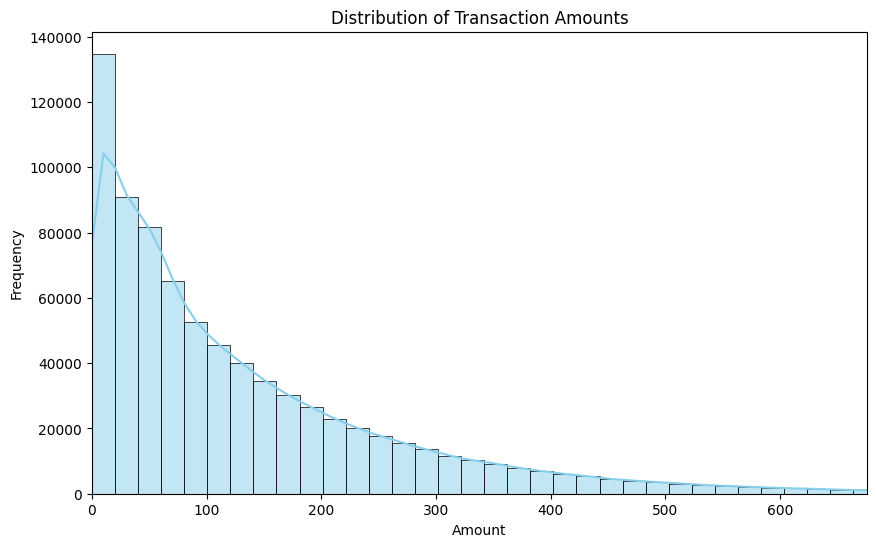

In [67]:
plt.figure(figsize=(10, 6))
sns.histplot(df['transactionAmount'], bins=100, kde=True, color='skyblue')
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.xlim(0, df['transactionAmount'].quantile(0.99))  # zoom in to avoid outliers dominating
plt.show()

**Transaction Time Analysis**

<ipython-input-68-b72041e11da0>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='hour', palette='viridis')


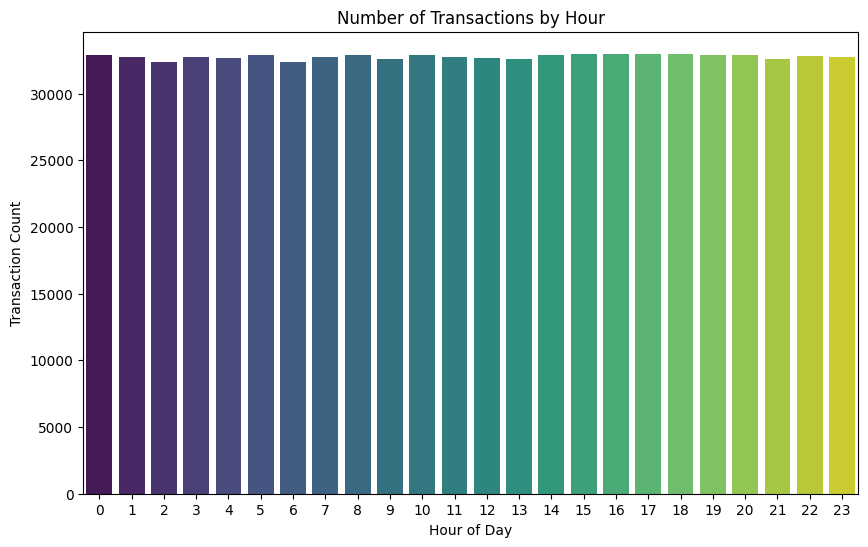

In [68]:
# Convert to datetime
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

# Extract hour
df['hour'] = df['transactionDateTime'].dt.hour

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='hour', palette='viridis')
plt.title("Number of Transactions by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.show()

**Merchant Category Frequency**

<ipython-input-69-bb9065378088>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette='coolwarm')


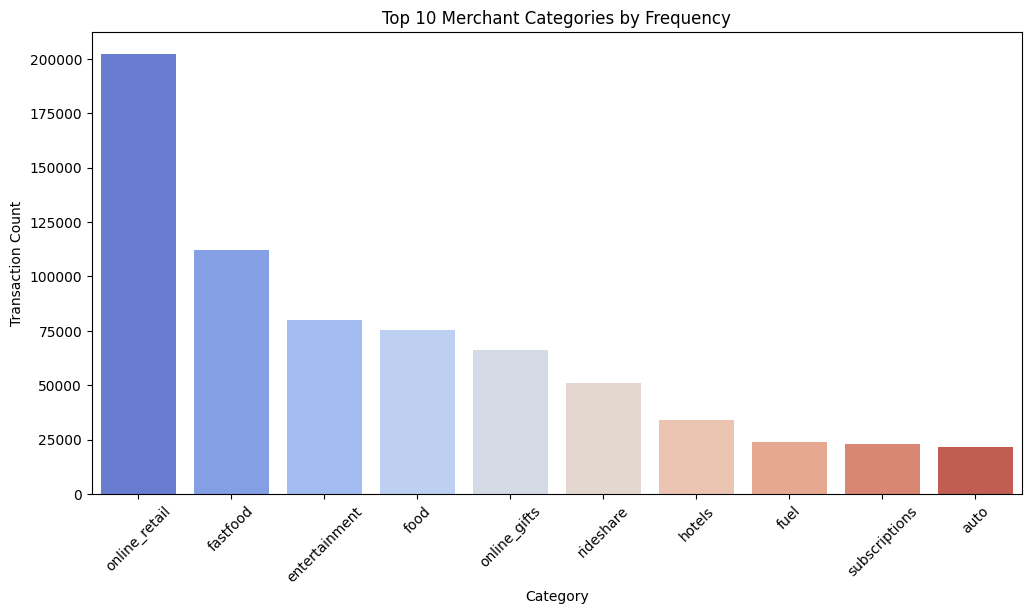

In [69]:
# Top 10 categories
top_categories = df['merchantCategoryCode'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.index, y=top_categories.values, palette='coolwarm')
plt.title("Top 10 Merchant Categories by Frequency")
plt.xlabel("Category")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.show()

**Transaction Type**

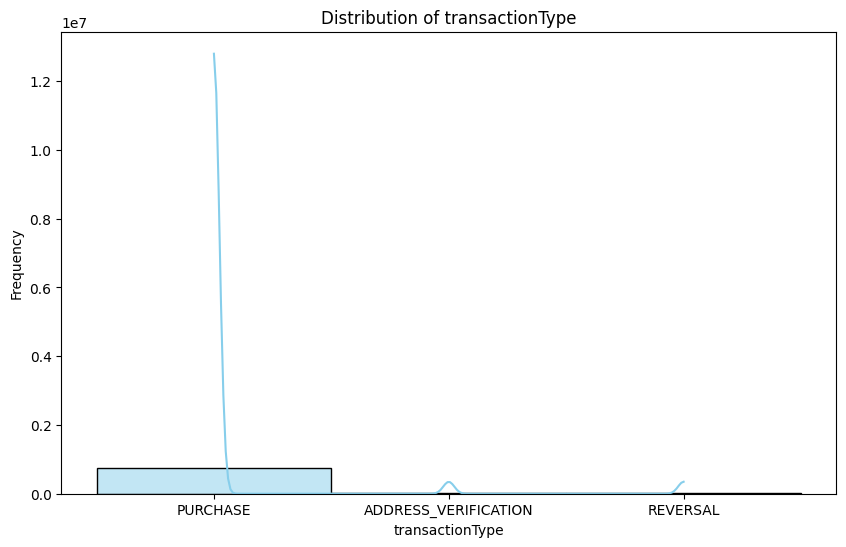

In [70]:
plt.figure(figsize=(10, 6))
sns.histplot(df['transactionType'], bins=5, kde=True, color='skyblue')
plt.title("Distribution of transactionType")
plt.xlabel("transactionType")
plt.ylabel("Frequency")
#plt.xlim(0, df['transactionType'].quantile(0.99))  # zoom in to avoid outliers dominating
plt.show()

**Card Present**

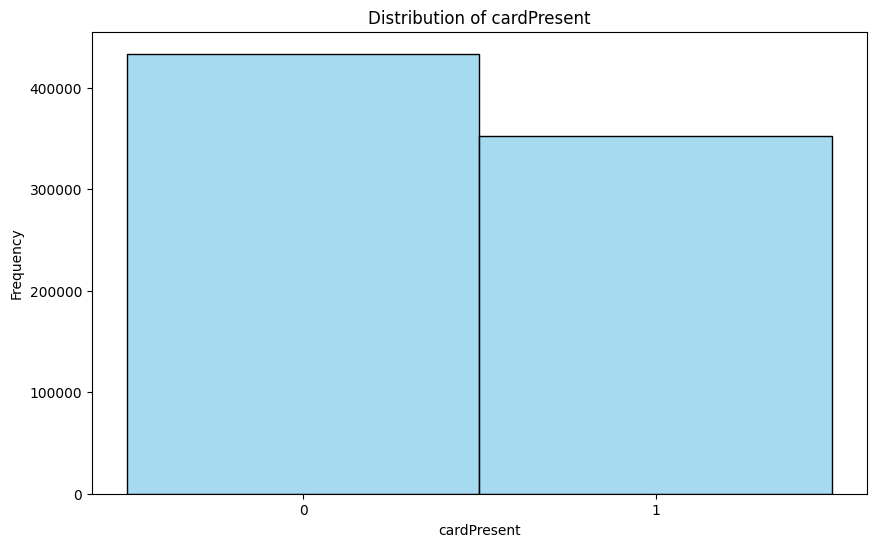

In [71]:
plt.figure(figsize=(10, 6))
sns.histplot(df['cardPresent'], bins=2, discrete=True, color='skyblue')
plt.title("Distribution of cardPresent")
plt.xlabel("cardPresent")
plt.ylabel("Frequency")
plt.xticks([0, 1])  # Ensure only 0 and 1 are shown on the x-axis
plt.show()

**Bivariate Analysis**

**Transaction Amount by Merchant Category**

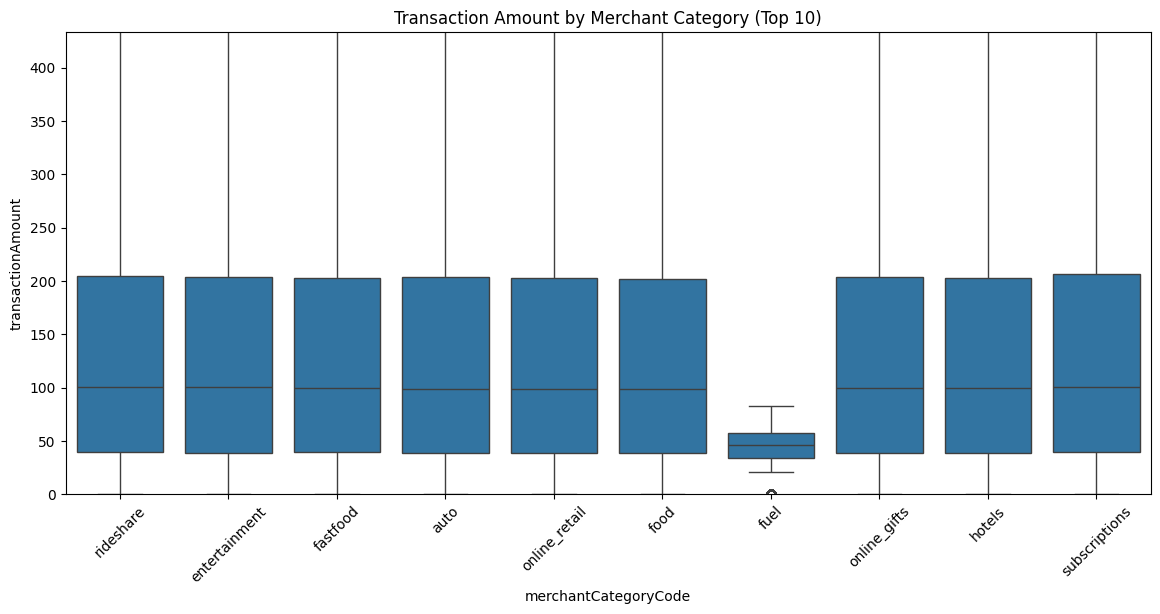

In [72]:
plt.figure(figsize=(14, 6))
top_categories = df['merchantCategoryCode'].value_counts().nlargest(10).index
sns.boxplot(data=df[df['merchantCategoryCode'].isin(top_categories)],
            x='merchantCategoryCode', y='transactionAmount')
plt.title('Transaction Amount by Merchant Category (Top 10)')
plt.xticks(rotation=45)
plt.ylim(0, df['transactionAmount'].quantile(0.95))  # zoom in
plt.show()

**Transaction Amount Over Hour of Day**

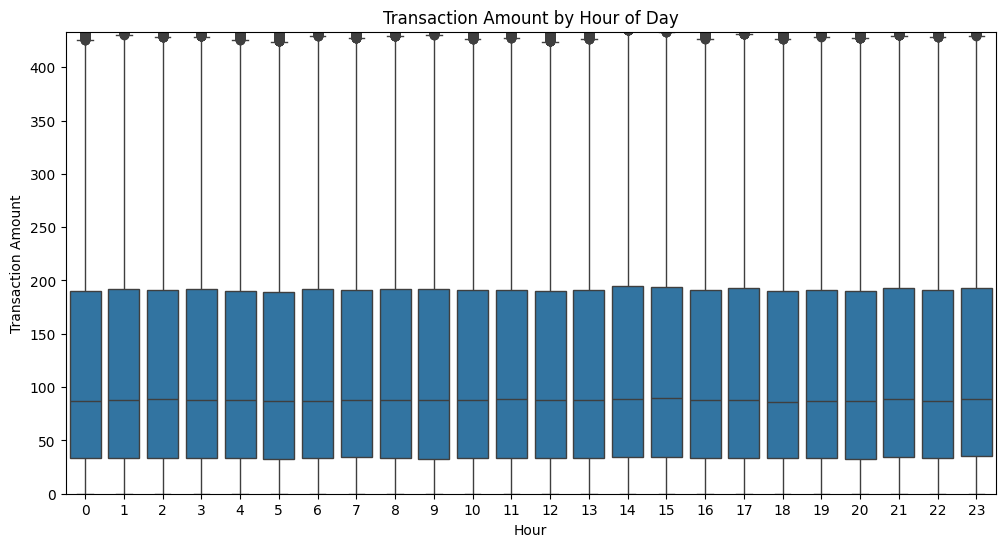

In [73]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='hour', y='transactionAmount')
plt.title("Transaction Amount by Hour of Day")
plt.ylim(0, df['transactionAmount'].quantile(0.95))  # to avoid outlier distortion
plt.xlabel("Hour")
plt.ylabel("Transaction Amount")
plt.show()

**Transaction Amount: Fraud vs Non-Fraud**



<ipython-input-74-6f71409e4264>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='isFraud', y='transactionAmount', palette='Set2')


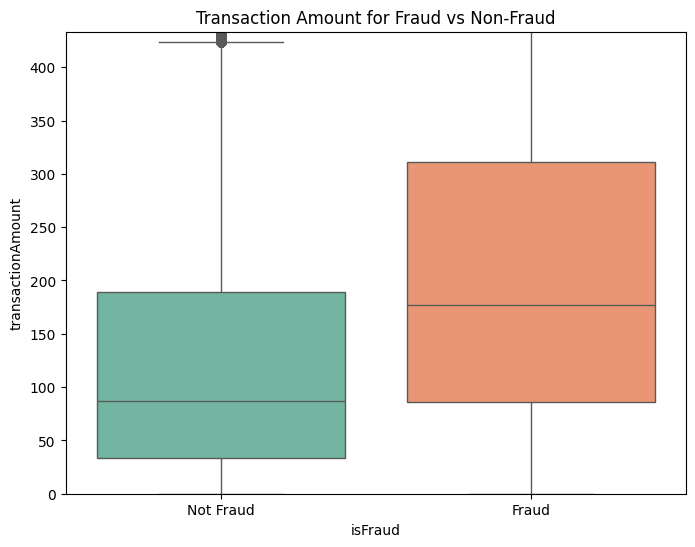

In [74]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='isFraud', y='transactionAmount', palette='Set2')
plt.title("Transaction Amount for Fraud vs Non-Fraud")
plt.ylim(0, df['transactionAmount'].quantile(0.95))
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()

**Fraud Rate by Merchant name and Category**

<ipython-input-75-9749ef82a0d2>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-75-9749ef82a0d2>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


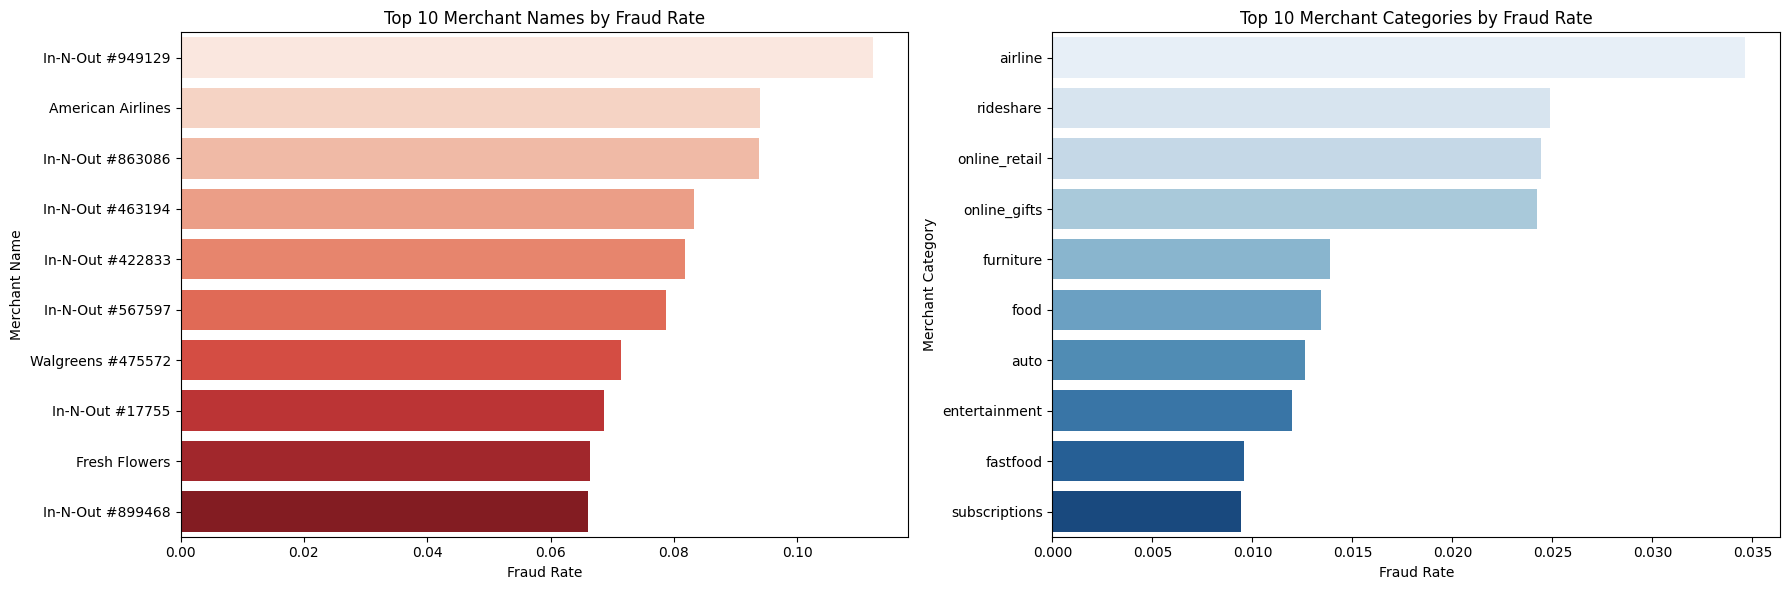

In [75]:
# Calculate top 10 merchant names by fraud rate
fraud_rate_merchant = df.groupby('merchantName')['isFraud'].mean().sort_values(ascending=False).head(10)

# Calculate top 10 merchant categories by fraud rate
fraud_rate_category = df.groupby('merchantCategoryCode')['isFraud'].mean().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for Merchant Names
sns.barplot(
    x=fraud_rate_merchant.values,
    y=fraud_rate_merchant.index,
    palette='Reds',
    ax=axes[0]
)
axes[0].set_title('Top 10 Merchant Names by Fraud Rate')
axes[0].set_xlabel('Fraud Rate')
axes[0].set_ylabel('Merchant Name')

# Plot for Merchant Categories
sns.barplot(
    x=fraud_rate_category.values,
    y=fraud_rate_category.index,
    palette='Blues',
    ax=axes[1]
)
axes[1].set_title('Top 10 Merchant Categories by Fraud Rate')
axes[1].set_xlabel('Fraud Rate')
axes[1].set_ylabel('Merchant Category')

plt.tight_layout()
plt.show()


**Fraud Rate by Card Present**

<ipython-input-76-bc860851d2eb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_card_present.index, y=fraud_card_present.values, palette='coolwarm')


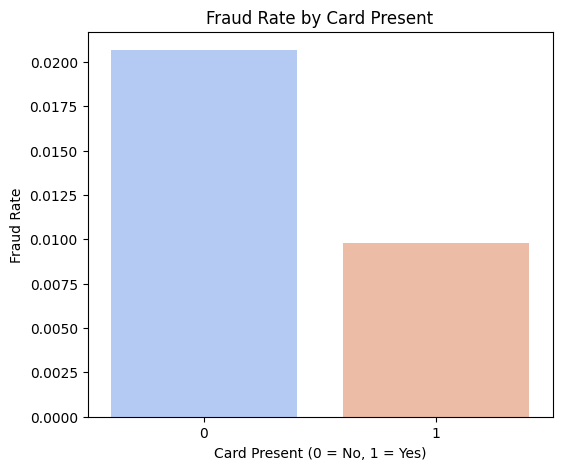

In [76]:
fraud_card_present = df.groupby('cardPresent')['isFraud'].mean()

plt.figure(figsize=(6, 5))
sns.barplot(x=fraud_card_present.index, y=fraud_card_present.values, palette='coolwarm')
plt.title("Fraud Rate by Card Present")
plt.xlabel("Card Present (0 = No, 1 = Yes)")
plt.ylabel("Fraud Rate")
plt.show()

**Fraud rate by hour of the day, day of the week and month**

<ipython-input-77-6d86c5273f36>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_day.index, y=fraud_by_day.values, palette='magma', ax=axes[1])
<ipython-input-77-6d86c5273f36>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_month.index, y=fraud_by_month.values, palette='flare', ax=axes[2])


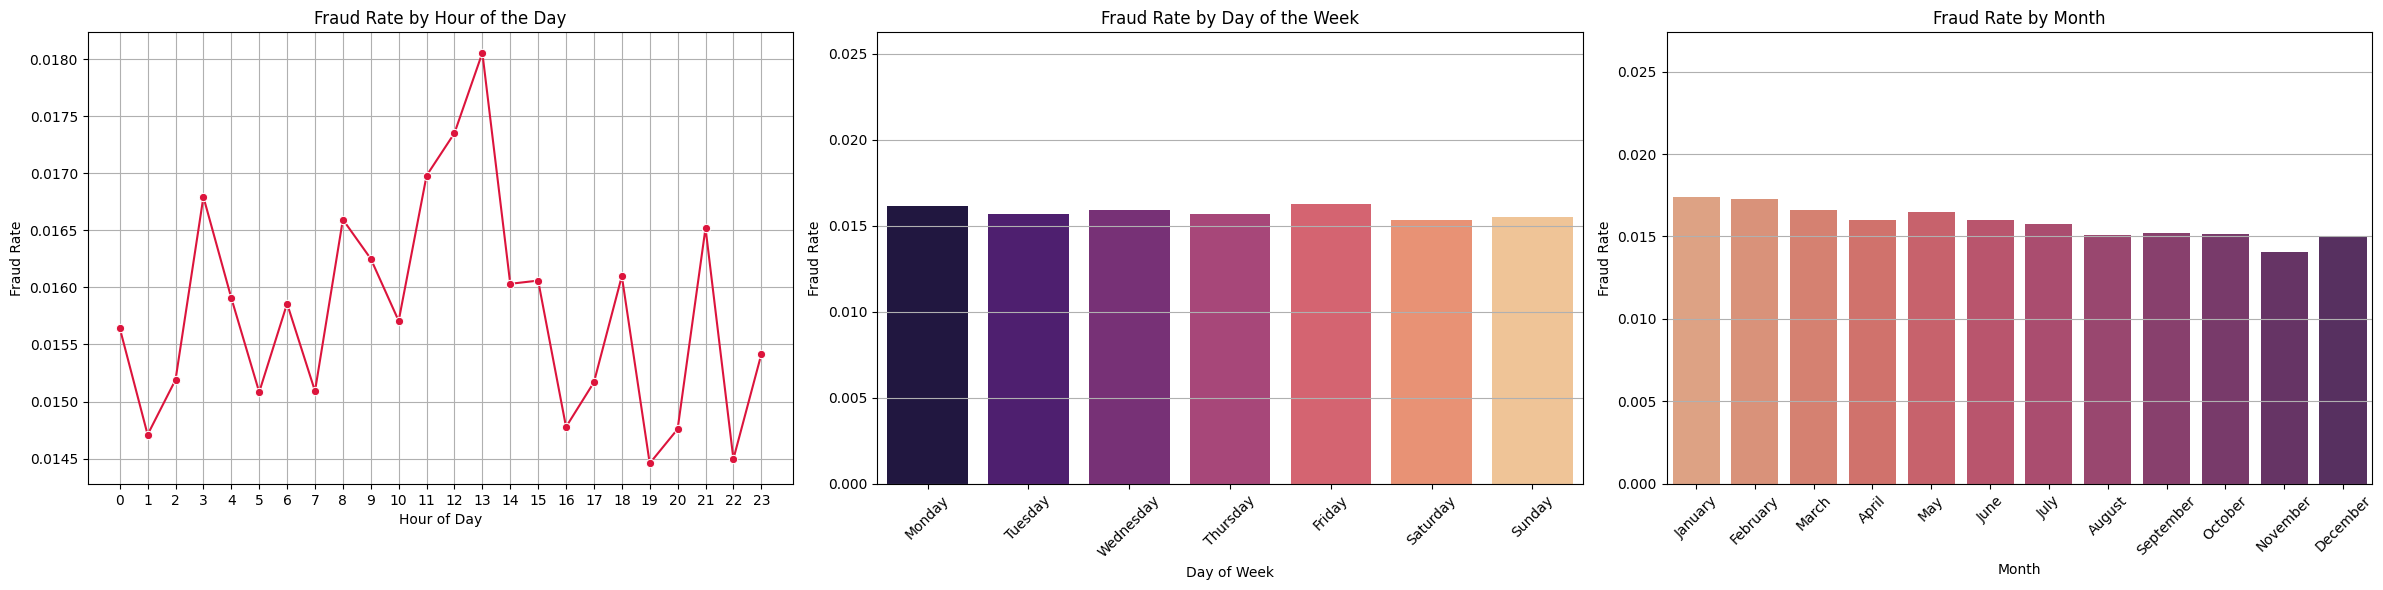

In [77]:
# Prepare the data (assuming df already loaded and transactionDateTime parsed)

# Fraud rate by hour
fraud_by_hour = df.groupby('hour')['isFraud'].mean()

# Extract day name and calculate fraud rate by day of week
df['day_of_week'] = df['transactionDateTime'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fraud_by_day = df.groupby('day_of_week')['isFraud'].mean().reindex(weekday_order)

# Extract month and calculate fraud rate by month
df['month'] = df['transactionDateTime'].dt.month_name()
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
fraud_by_month = df.groupby('month')['isFraud'].mean().reindex(month_order)

# Plot all three subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Fraud rate by hour
sns.lineplot(x=fraud_by_hour.index, y=fraud_by_hour.values, marker='o', color='crimson', ax=axes[0])
axes[0].set_title("Fraud Rate by Hour of the Day")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Fraud Rate")
axes[0].set_xticks(range(0, 24))
axes[0].grid(True)

# Fraud rate by day of week
sns.barplot(x=fraud_by_day.index, y=fraud_by_day.values, palette='magma', ax=axes[1])
axes[1].set_title("Fraud Rate by Day of the Week")
axes[1].set_xlabel("Day of Week")
axes[1].set_ylabel("Fraud Rate")
axes[1].set_ylim(0, fraud_by_day.max() + 0.01)
axes[1].grid(axis='y')
axes[1].tick_params(axis='x', rotation=45)

# Fraud rate by month
sns.barplot(x=fraud_by_month.index, y=fraud_by_month.values, palette='flare', ax=axes[2])
axes[2].set_title("Fraud Rate by Month")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("Fraud Rate")
axes[2].set_ylim(0, fraud_by_month.max() + 0.01)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y')

plt.tight_layout()
plt.show()

df.drop(columns=['day_of_week', 'month'], inplace=True)

**Fraud rate by Acquirer Country**

<ipython-input-78-6d2769b09c79>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_fraud_countries.index, y=top_fraud_countries.values, palette='rocket')


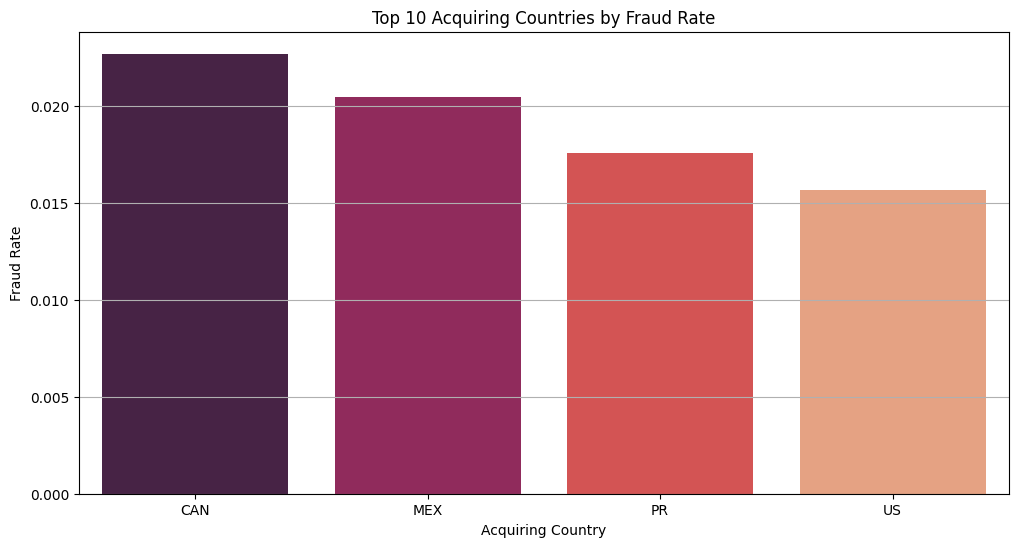

In [78]:
# Drop missing values in acqCountry
df_country = df.dropna(subset=['acqCountry'])

# Compute fraud rate by acqCountry
fraud_by_country = df_country.groupby('acqCountry')['isFraud'].mean()

# Sort by fraud rate and take top 10
top_fraud_countries = fraud_by_country.sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=top_fraud_countries.index, y=top_fraud_countries.values, palette='rocket')
plt.title("Top 10 Acquiring Countries by Fraud Rate")
plt.xlabel("Acquiring Country")
plt.ylabel("Fraud Rate")
plt.grid(axis='y')
plt.show()

**Peak Spending Times (Hourly & Daily Patterns)**

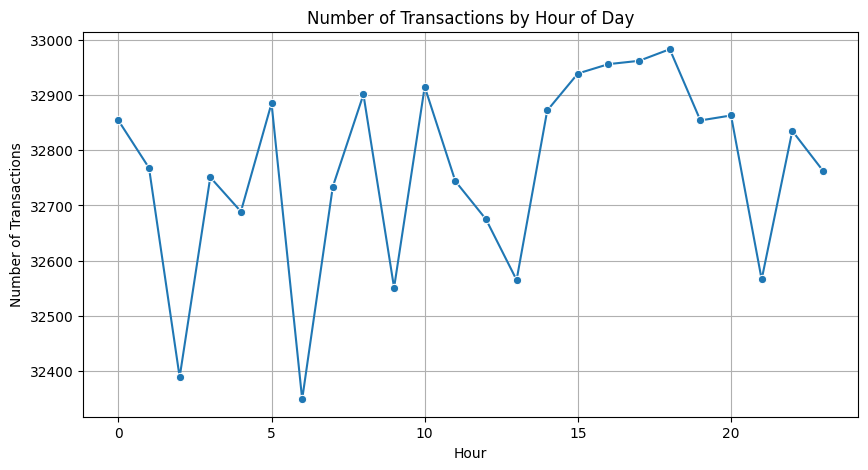

In [79]:
# Already extracted 'hour' column
hourly_counts = df['hour'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o')
plt.title("Number of Transactions by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Transactions")
plt.grid(True)
plt.show()

**Number of Transactions by Day of Week**

<ipython-input-80-5f037a78b293>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_counts.index, y=daily_counts.values, palette='Set3')


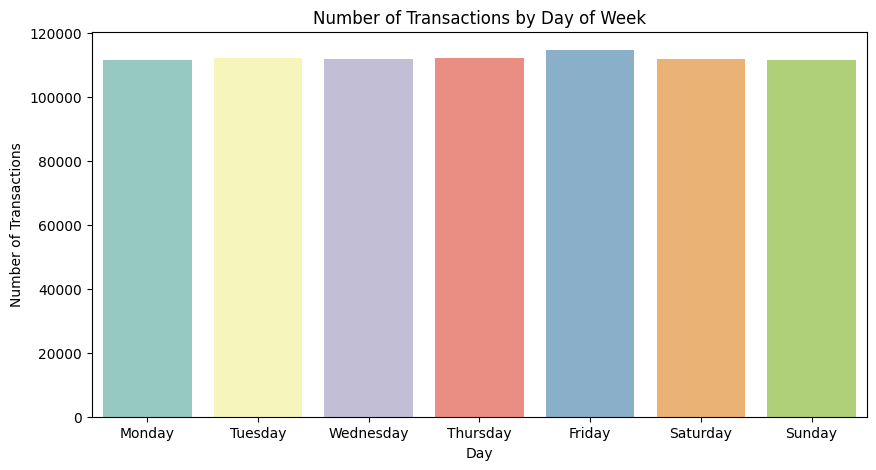

In [80]:
df['day_of_week'] = df['transactionDateTime'].dt.day_name()

daily_counts = df['day_of_week'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 5))
sns.barplot(x=daily_counts.index, y=daily_counts.values, palette='Set3')
plt.title("Number of Transactions by Day of Week")
plt.xlabel("Day")
plt.ylabel("Number of Transactions")
plt.show()

df.drop(columns=['day_of_week'], inplace=True)

**High-Value Merchant Categories**

<ipython-input-81-c8a91fc2c658>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_amount_by_category.index, y=avg_amount_by_category.values, palette='Blues_d')


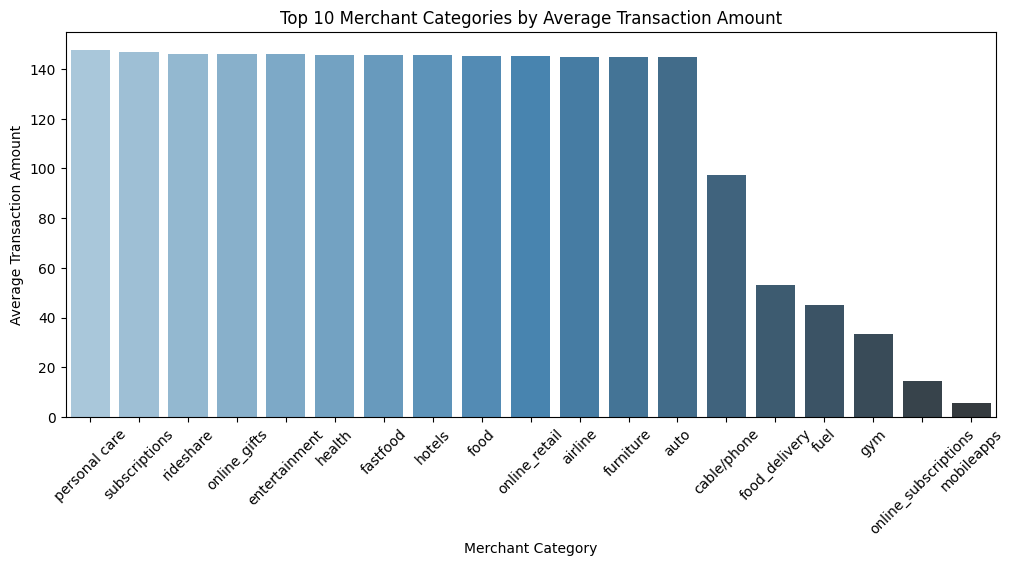

In [81]:
avg_amount_by_category = df.groupby('merchantCategoryCode')['transactionAmount'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=avg_amount_by_category.index, y=avg_amount_by_category.values, palette='Blues_d')
plt.title("Top 10 Merchant Categories by Average Transaction Amount")
plt.xlabel("Merchant Category")
plt.ylabel("Average Transaction Amount")
plt.xticks(rotation=45)
plt.show()

# **DATA CLENSING**

**Check for missing values**

In [82]:
# Check for missing values
print(df.isnull().sum())

accountNumber                  0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
merchantName                   0
transactionAmount              0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
hour                           0
dtype: int64


**Missing percentage**

In [83]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage = missing_percentage.map(lambda x: f"{x:.2f}%")
print(missing_percentage)

accountNumber               0.00%
creditLimit                 0.00%
availableMoney              0.00%
transactionDateTime         0.00%
merchantName                0.00%
transactionAmount           0.00%
acqCountry                  0.58%
merchantCountryCode         0.09%
posEntryMode                0.52%
posConditionCode            0.05%
merchantCategoryCode        0.00%
currentExpDate              0.00%
accountOpenDate             0.00%
dateOfLastAddressChange     0.00%
cardCVV                     0.00%
enteredCVV                  0.00%
cardLast4Digits             0.00%
transactionType             0.09%
currentBalance              0.00%
cardPresent                 0.00%
expirationDateKeyInMatch    0.00%
isFraud                     0.00%
hour                        0.00%
dtype: object


**Fill missing values**

In [84]:
categorical_missing = [
    'acqCountry',
    'merchantCountryCode',
    'posEntryMode',
    'posConditionCode',
    'transactionType'
]

for col in categorical_missing:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)

missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage = missing_percentage.map(lambda x: f"{x:.2f}%")
print(missing_percentage)

<ipython-input-84-3bdd486a1d19>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)


accountNumber               0.00%
creditLimit                 0.00%
availableMoney              0.00%
transactionDateTime         0.00%
merchantName                0.00%
transactionAmount           0.00%
acqCountry                  0.00%
merchantCountryCode         0.00%
posEntryMode                0.00%
posConditionCode            0.00%
merchantCategoryCode        0.00%
currentExpDate              0.00%
accountOpenDate             0.00%
dateOfLastAddressChange     0.00%
cardCVV                     0.00%
enteredCVV                  0.00%
cardLast4Digits             0.00%
transactionType             0.00%
currentBalance              0.00%
cardPresent                 0.00%
expirationDateKeyInMatch    0.00%
isFraud                     0.00%
hour                        0.00%
dtype: object


**Removing outliers based on transaction amount**

<ipython-input-85-9ff045b5a4e5>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


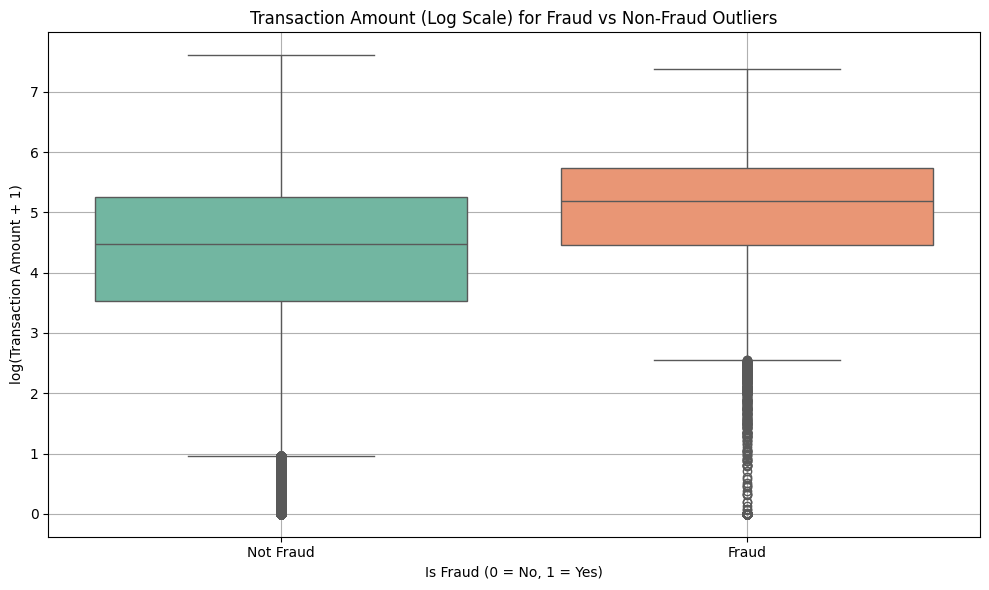

In [85]:
plt.figure(figsize=(10, 6))

# Add 1 to avoid log(0)
sns.boxplot(
    data=df,
    x='isFraud',
    y=np.log1p(df['transactionAmount']),  # log1p = log(1 + x) to handle zero values
    palette='Set2',
    showfliers=True
)

plt.title("Transaction Amount (Log Scale) for Fraud vs Non-Fraud Outliers")
plt.xlabel("Is Fraud (0 = No, 1 = Yes)")
plt.ylabel("log(Transaction Amount + 1)")
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.grid(True)
plt.tight_layout()
plt.show()


**Removing the outliers**

In [86]:
# Function to calculate IQR bounds
def get_outlier_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Get bounds separately for fraud and non-fraud
fraud_bounds = get_outlier_bounds(df[df['isFraud'] == 1]['transactionAmount'])
nonfraud_bounds = get_outlier_bounds(df[df['isFraud'] == 0]['transactionAmount'])

# Create conditions for inliers
fraud_condition = (
    (df['isFraud'] == 1) &
    (df['transactionAmount'] >= fraud_bounds[0]) &
    (df['transactionAmount'] <= fraud_bounds[1])
)

nonfraud_condition = (
    (df['isFraud'] == 0) &
    (df['transactionAmount'] >= nonfraud_bounds[0]) &
    (df['transactionAmount'] <= nonfraud_bounds[1])
)

# Keep only inliers from both groups
df_no_outliers = df[fraud_condition | nonfraud_condition].copy()

print(f"Original shape: {df.shape}")
print(f"After removing outliers: {df_no_outliers.shape}")


Original shape: (786363, 23)
After removing outliers: (745612, 23)


# **Splitting the data**

In [87]:
# Define features (X) and target (y)
X = df_no_outliers.drop(columns=['isFraud'])  # drop target
y = df_no_outliers['isFraud']

# Split with stratification to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80% train, 20% test (adjust as needed)
    random_state=42,     # for reproducibility
    stratify=y           # important for imbalanced data!
)

print(f"Training set fraud rate: {y_train.mean():.4f}")
print(f"Test set fraud rate: {y_test.mean():.4f}")

Training set fraud rate: 0.0160
Test set fraud rate: 0.0160


# **Encode non-numeric columns**

**Encode transactionDateTime**

In [88]:
def extract_datetime_features(df, datetime_col='transactionDateTime'):
    """
    Extract datetime features from a datetime column in the dataframe.

    Parameters:
        df (pd.DataFrame): Input dataframe containing the datetime column.
        datetime_col (str): Name of the datetime column to extract features from.

    Returns:
        pd.DataFrame: DataFrame with new datetime features and original datetime column dropped.
    """
    df = df.copy()  # avoid modifying original dataframe

    df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')

    df['transactionHour'] = df[datetime_col].dt.hour              # Hour of the day (0–23)
    df['transactionDay'] = df[datetime_col].dt.day                # Day of month (1–31)
    df['transactionWeekday'] = df[datetime_col].dt.weekday        # Monday=0, Sunday=6
    df['transactionMonth'] = df[datetime_col].dt.month            # Month (1–12)
    df['transactionYear'] = df[datetime_col].dt.year              # Year
    df['isWeekend'] = df[datetime_col].dt.weekday >= 5            # True if Saturday/Sunday

    #df.drop(columns=[datetime_col], inplace=True)

    return df

X_train = extract_datetime_features(X_train, datetime_col='transactionDateTime')
X_test = extract_datetime_features(X_test, datetime_col='transactionDateTime')

**Encode merchantName**

In [89]:
class SmoothedTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column, smoothing=100):
        self.column = column
        self.smoothing = smoothing
        self.mapping_ = None
        self.global_mean_ = None

    def fit(self, X, y):
        # Store global mean from target
        self.global_mean_ = y.mean()

        # Combine X and y to compute group stats
        temp = pd.DataFrame({self.column: X[self.column], 'target': y})
        agg = temp.groupby(self.column)['target'].agg(['mean', 'count'])
        agg['smoothed'] = (
            agg['mean'] * agg['count'] + self.global_mean_ * self.smoothing
        ) / (agg['count'] + self.smoothing)

        self.mapping_ = agg['smoothed']
        return self

    def transform(self, X):
        X = X.copy()
        X[f'{self.column}_target'] = X[self.column].map(self.mapping_).fillna(self.global_mean_)
        X.drop(columns=[self.column], inplace=True)
        return X

from sklearn.pipeline import Pipeline

encoder_pipeline = Pipeline([
    ('merchant_encoder', SmoothedTargetEncoder(column='merchantName', smoothing=100)),
])


# Fit on training data
encoder_pipeline.fit(X_train, y_train)

# Transform train and test
X_train = encoder_pipeline.transform(X_train)
X_test = encoder_pipeline.transform(X_test)

**Encode acqCountry**

In [90]:
X_train = pd.get_dummies(X_train, columns=['acqCountry'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['acqCountry'], drop_first=True)

**Encode merchantCountryCode**

In [91]:
X_train = pd.get_dummies(X_train, columns=['merchantCountryCode'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['merchantCountryCode'], drop_first=True)

**Encode merchantCategoryCode**

In [92]:
X_train = pd.get_dummies(X_train, columns=['merchantCategoryCode'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['merchantCategoryCode'], drop_first=True)

**Encode currentExpDate**

In [93]:
def parse_current_exp_date(df):
    # Ensure transactionDateTime is datetime
    df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

    def get_expiry(row):
        val = str(row['currentExpDate']).strip()
        txn_date = row['transactionDateTime']

        if pd.isna(val) or val.lower() in ['nan', 'none']:
            return np.nan

        # Format: DD-MMM (e.g., 21-May)
        if re.match(r'^\d{1,2}-[A-Za-z]{3}$', val):
            try:
                day, month = val.split('-')
                month = month.capitalize()
                exp_month = datetime.strptime(month, '%b').month
                txn_month = txn_date.month
                txn_year = txn_date.year

                # If expiry month is before transaction month, assume next year
                if exp_month < txn_month:
                    exp_year = txn_year + 1
                else:
                    exp_year = txn_year

                return pd.Timestamp(year=exp_year, month=exp_month, day=1)
            except:
                return np.nan

        # Format: MMM-YY (e.g., Jul-32)
        elif re.match(r'^[A-Za-z]{3}-\d{2}$', val):
            try:
                month, year_suffix = val.split('-')
                month = month.capitalize()
                year_suffix = int(year_suffix)
                # Convert to 4-digit year: assume 00–49 = 2000–2049, 50–99 = 1950–1999
                if year_suffix <= 49:
                    year = 2000 + year_suffix
                else:
                    year = 1900 + year_suffix
                return pd.Timestamp(year=year, month=datetime.strptime(month, '%b').month, day=1)
            except:
                return np.nan

        return np.nan

    # Step 1: Parse all dates
    df['exp_date'] = df.apply(get_expiry, axis=1)

    # Step 2: Fill failed parses with a neutral guess (e.g., 6 months after txn)
    df['exp_date'].fillna(df['transactionDateTime'] + pd.DateOffset(months=6), inplace=True)

    # Step 3: Calculate months_to_expiry
    df['months_to_expiry'] = ((df['exp_date'] - df['transactionDateTime']) / pd.Timedelta(days=30)).round().astype('int')

    return df

X_train = parse_current_exp_date(X_train)
X_test = parse_current_exp_date(X_test)


# Apply parser
X_train.drop(columns=['currentExpDate', 'exp_date', 'transactionDateTime'], inplace=True)
X_test.drop(columns=['currentExpDate', 'exp_date', 'transactionDateTime'], inplace=True)

<ipython-input-93-d3b0ff20f83a>:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['exp_date'].fillna(df['transactionDateTime'] + pd.DateOffset(months=6), inplace=True)
<ipython-input-93-d3b0ff20f83a>:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[c

**Encode accountOpenDate**

In [94]:
def process_account_open_date(df):
    """
    Converts 'accountOpenDate' to datetime, calculates account age in days and months,
    and drops the original column.

    Parameters:
        df (pd.DataFrame): Input DataFrame with 'accountOpenDate' column.

    Returns:
        pd.DataFrame: Updated DataFrame with account age features.
    """
    df = df.copy()

    df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'], errors='coerce')
    today = pd.to_datetime('today')

    df['account_age_days'] = (today - df['accountOpenDate']).dt.days
    df['account_age_months'] = (df['account_age_days'] / 30.44).round().astype('Int32')

    df.drop(columns=['accountOpenDate'], inplace=True)

    return df

X_train = process_account_open_date(X_train)
X_test = process_account_open_date(X_test)

#X_train.info()

**Encode dateOfLastAddressChange**

In [95]:
def process_address_change_date(df):
    """
    Converts 'dateOfLastAddressChange' to datetime, calculates how long ago the address was changed
    in days and months, and drops the original column.

    Parameters:
        df (pd.DataFrame): Input DataFrame with 'dateOfLastAddressChange' column.

    Returns:
        pd.DataFrame: Updated DataFrame with address change age features.
    """
    df = df.copy()

    df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'], errors='coerce')
    today = pd.to_datetime('today')

    df['address_change_days_ago'] = (today - df['dateOfLastAddressChange']).dt.days
    df['address_change_months_ago'] = (df['address_change_days_ago'] / 30.44).round().astype('Int32')

    df.drop(columns=['dateOfLastAddressChange'], inplace=True)

    return df

X_train = process_address_change_date(X_train)
X_test = process_address_change_date(X_test)

#X_train.info()

**Encode transactionType**

In [96]:
def encode_transaction_type(df, encoder=None):
    """
    Label encodes the 'transactionType' column and drops the original.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing 'transactionType'.
        encoder (LabelEncoder, optional): Pre-fitted LabelEncoder for consistency between train/test.

    Returns:
        df (pd.DataFrame): Updated DataFrame with encoded column.
        encoder (LabelEncoder): The fitted LabelEncoder (useful for test data).
    """
    df = df.copy()

    df['transactionType'] = df['transactionType'].fillna('Unknown')

    if encoder is None:
        encoder = LabelEncoder()
        df['transactionType_encoded'] = encoder.fit_transform(df['transactionType'])
    else:
        df['transactionType_encoded'] = encoder.transform(df['transactionType'])

    df.drop(columns=['transactionType'], inplace=True)

    return df, encoder

X_train, tx_type_encoder = encode_transaction_type(X_train)
X_test, _ = encode_transaction_type(X_test, encoder=tx_type_encoder)


# **Check for Multi-colinearity**

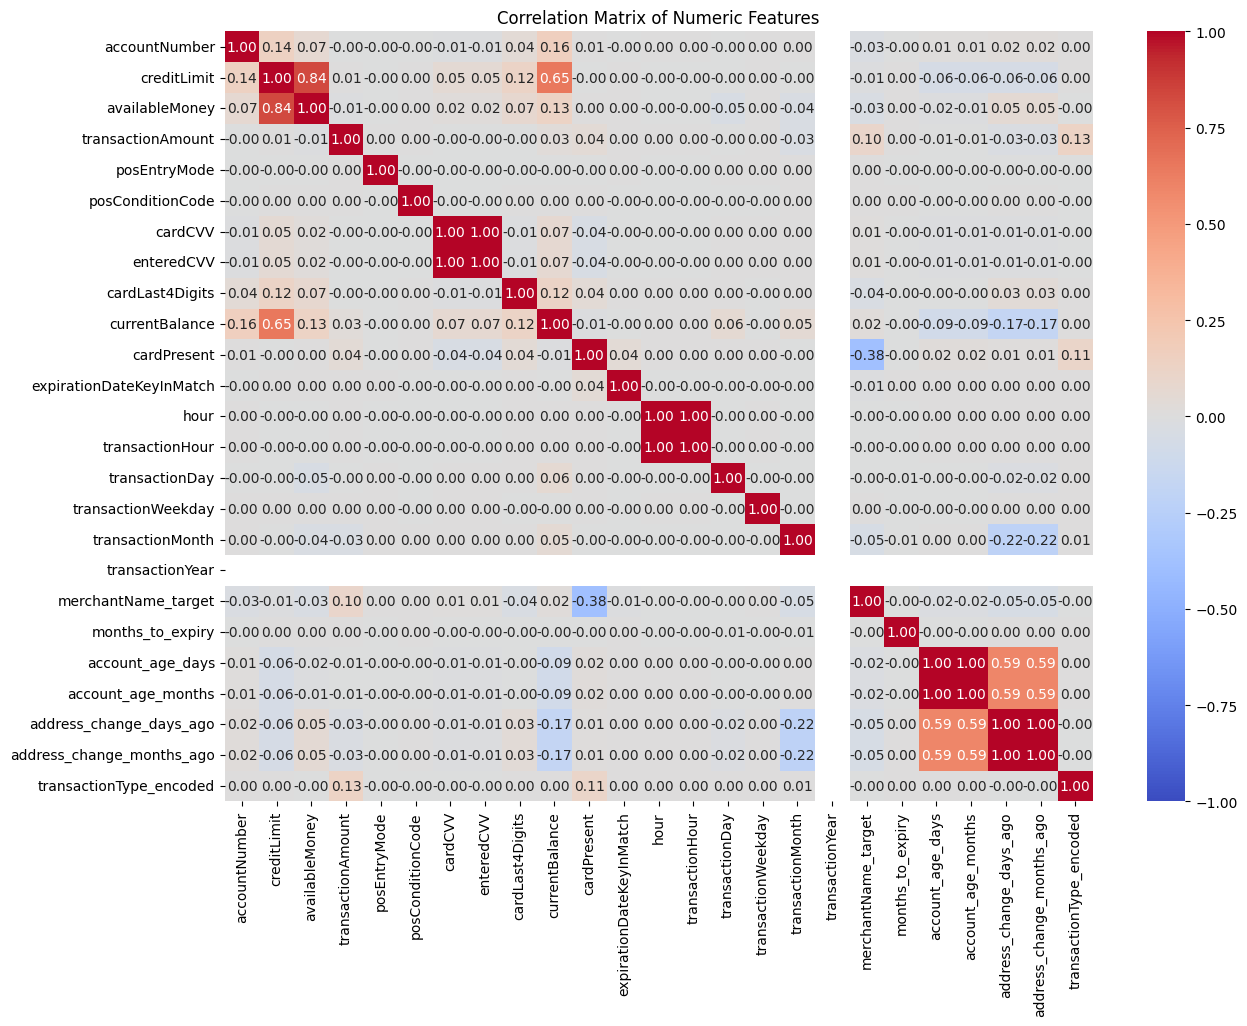

In [97]:
# Select only numeric features (exclude bool and categorical)
numeric_cols = X_train.select_dtypes(include=['int64', 'float64', 'int32']).columns

# Correlation matrix
corr_matrix = X_train[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# **Detect multicollinearity and delete unwanted columns**

In [98]:
def remove_highly_correlated_features(X_train, X_test, threshold=0.9):
    # Compute correlation matrix
    corr_matrix = X_train.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop from both train and test
    X_train_dropped = X_train.drop(columns=to_drop)
    X_test_dropped = X_test.drop(columns=to_drop)

    print(f"Columns dropped due to multicollinearity (threshold={threshold}):")
    print(to_drop)

    return X_train_dropped, X_test_dropped

X_train_cleaned, X_test_cleaned = remove_highly_correlated_features(X_train, X_test)

X_train = X_train_cleaned
X_test = X_test_cleaned

Columns dropped due to multicollinearity (threshold=0.9):
['enteredCVV', 'transactionHour', 'merchantCountryCode_MEX', 'merchantCountryCode_PR', 'merchantCountryCode_US', 'account_age_months', 'address_change_months_ago']


# **Model Training**

**Logistic Regression**

In [99]:
with tf.device('/GPU:0'):
  # File paths
  model_path = '/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/capstone-1/dump/log_grid.pkl'
  metrics_path = '/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/capstone-1/dump/log_metrics.pkl'

  log_grid = None
  log_time = None
  log_best = None
  log_acc = None
  log_rec = None
  log_f1 = None
  log_precision = None
  log_threshold = None

  if os.path.exists(model_path) and os.path.exists(metrics_path):
      print("Loading saved logistic regression model...")
      log_grid = joblib.load(model_path)
      log_metrics_loaded = joblib.load(metrics_path)

      log_time = log_metrics_loaded['log_time']
      log_best = log_metrics_loaded['log_best']
      log_acc = log_metrics_loaded['log_acc']
      log_rec = log_metrics_loaded['log_rec']
      log_f1 = log_metrics_loaded['log_f1']
      log_precision = log_metrics_loaded['log_precision']
      log_threshold = log_metrics_loaded['log_threshold']

  else:
      print("Training logistic regression model with SMOTE and threshold tuning...")

      # Pipeline with SMOTE
      log_pipe = ImbPipeline([
          ('scaler', StandardScaler()),
          ('smote', SMOTE(random_state=42)),
          ('clf', LogisticRegression(class_weight='balanced', solver='liblinear'))
      ])

      # Hyperparameter grid
      log_params = {
          'clf__penalty': ['l1', 'l2'],
          'clf__fit_intercept': [True, False],
          'clf__max_iter': [500, 1000, 1500]
      }

      # Grid search
      start = time.time()
      log_grid = GridSearchCV(log_pipe, log_params, scoring='f1', cv=3, n_jobs=-1, verbose=1)
      log_grid.fit(X_train, y_train)
      stop = time.time()

      # Predict probabilities for threshold tuning
      y_proba = log_grid.predict_proba(X_test)[:, 1]

      # Threshold tuning: search for best F1
      best_f1 = 0
      best_thresh = 0.5
      for thresh in np.arange(0.1, 0.9, 0.01):
          y_pred_thresh = (y_proba >= thresh).astype(int)
          score = f1_score(y_test, y_pred_thresh)
          if score > best_f1:
              best_f1 = score
              best_thresh = thresh

      # Final predictions using best threshold
      y_pred = (y_proba >= best_thresh).astype(int)

      # Metrics
      log_time = stop - start
      log_best = log_grid.best_params_
      log_acc = accuracy_score(y_test, y_pred)
      log_rec = recall_score(y_test, y_pred)
      log_f1 = f1_score(y_test, y_pred)
      log_precision = precision_score(y_test, y_pred)
      log_threshold = best_thresh

      # Save model
      joblib.dump(log_grid, model_path)
      joblib.dump({
          'log_time': log_time,
          'log_best': log_best,
          'log_acc': log_acc,
          'log_rec': log_rec,
          'log_f1': log_f1,
          'log_precision': log_precision,
          'log_threshold': log_threshold
      }, metrics_path)

      print(f"Model saved to {model_path}")
      print(f"Metrics saved to {metrics_path}")
      print(f"Optimal threshold: {best_thresh:.2f}, F1: {best_f1:.4f}")


Loading saved logistic regression model...


In [100]:
log_best

{'clf__fit_intercept': True, 'clf__max_iter': 500, 'clf__penalty': 'l2'}

**XGBoost**

In [101]:
with tf.device('/GPU:0'):
  # File paths
  model_path = '/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/capstone-1/dump/xgb_grid.pkl'
  metrics_path = '/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/capstone-1/dump/xgb_metrics.pkl'

  xgb_grid = None
  xgb_time = None
  xgb_best = None
  xgb_acc = None
  xgb_rec = None
  xgb_f1 = None
  xgb_precision = None
  xgb_threshold = None

  # Load model + metrics if they exist
  if os.path.exists(model_path) and os.path.exists(metrics_path):
      print("Loading saved XGBoost model and metrics...")
      xgb_grid = joblib.load(model_path)
      xgb_metrics = joblib.load(metrics_path)

      xgb_time = xgb_metrics['xgb_time']
      xgb_best = xgb_metrics['xgb_best']
      xgb_acc = xgb_metrics['xgb_acc']
      xgb_rec = xgb_metrics['xgb_rec']
      xgb_f1 = xgb_metrics['xgb_f1']
      xgb_precision = xgb_metrics['xgb_precision']
      xgb_threshold = xgb_metrics['xgb_threshold']

  else:
      print("Training new XGBoost model with SMOTE and threshold tuning...")

      # Dynamically compute scale_pos_weight (for comparison grid, even if using SMOTE)
      scale_weight = (y_train == 0).sum() / (y_train == 1).sum()

      # Build pipeline: SMOTE + XGBoost
      xgb_pipe = ImbPipeline([
          ('scaler', StandardScaler()),
          ('smote', SMOTE(random_state=42)),
          ('clf', XGBClassifier(
              use_label_encoder=False,
              eval_metric='logloss',
              random_state=42,
              objective='binary:logistic',
              scale_pos_weight=1  # since SMOTE balances classes
          ))
      ])

      # Hyperparameter grid
      xgb_params = {
          'clf__n_estimators': [100, 200],
          'clf__max_depth': [3, 6, 10],
          'clf__learning_rate': [0.01, 0.1, 0.2],
          'clf__subsample': [0.6, 0.8, 1.0],
          'clf__colsample_bytree': [0.6, 0.8, 1.0],
          'clf__scale_pos_weight': [1, scale_weight, scale_weight * 1.5]  # test even with SMOTE
      }

      # Train
      start = time.time()
      xgb_grid = RandomizedSearchCV(xgb_pipe, xgb_params, scoring='f1', cv=3, n_iter=10, verbose=1, n_jobs=-1)
      xgb_grid.fit(X_train, y_train)
      stop = time.time()

      # Predict probabilities
      y_proba = xgb_grid.predict_proba(X_test)[:, 1]

      # Threshold tuning
      best_f1 = 0
      best_thresh = 0.5
      for thresh in np.arange(0.1, 0.9, 0.01):
          y_pred_thresh = (y_proba >= thresh).astype(int)
          score = f1_score(y_test, y_pred_thresh)
          if score > best_f1:
              best_f1 = score
              best_thresh = thresh

      # Final prediction using optimal threshold
      y_pred = (y_proba >= best_thresh).astype(int)

      # Metrics
      xgb_time = stop - start
      xgb_best = xgb_grid.best_params_
      xgb_acc = accuracy_score(y_test, y_pred)
      xgb_rec = recall_score(y_test, y_pred)
      xgb_f1 = f1_score(y_test, y_pred)
      xgb_precision = precision_score(y_test, y_pred)
      xgb_threshold = best_thresh

      # Save metrics
      xgb_metrics = {
          'xgb_time': xgb_time,
          'xgb_best': xgb_best,
          'xgb_acc': xgb_acc,
          'xgb_rec': xgb_rec,
          'xgb_f1': xgb_f1,
          'xgb_precision': xgb_precision,
          'xgb_threshold': xgb_threshold
      }

      joblib.dump(xgb_grid, model_path)
      joblib.dump(xgb_metrics, metrics_path)

      print("Model saved to", model_path)
      print("Metrics saved to", metrics_path)
      print(f"Best threshold: {xgb_threshold:.2f}, F1: {xgb_f1:.4f}")


Loading saved XGBoost model and metrics...


**Support Vector Classifier (SVC)**

In [102]:
with tf.device('/GPU:0'):
  # File paths
  model_path = '/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/capstone-1/dump/svc_grid.pkl'
  metrics_path = '/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/capstone-1/dump/svc_metrics.pkl'

  svc_grid = None
  svc_time = None
  svc_best = None
  svc_acc = None
  svc_rec = None
  svc_f1 = None
  svc_precision = None
  svc_threshold = None

  # Load if already saved
  if os.path.exists(model_path) and os.path.exists(metrics_path):
      print("Loading saved SVC model and metrics...")
      svc_grid = joblib.load(model_path)
      svc_metrics_loaded = joblib.load(metrics_path)

      svc_time = svc_metrics_loaded['svc_time']
      svc_best = svc_metrics_loaded['svc_best']
      svc_acc = svc_metrics_loaded['svc_acc']
      svc_rec = svc_metrics_loaded['svc_rec']
      svc_f1 = svc_metrics_loaded['svc_f1']
      svc_precision = svc_metrics_loaded['svc_precision']
      svc_threshold = svc_metrics_loaded['svc_threshold']

  else:
      print("Training new SVC model with SMOTE and threshold tuning...")

      # Pipeline with SMOTE + SVC
      svc_pipe = ImbPipeline([
          ('scaler', StandardScaler()),
          ('smote', SMOTE(random_state=42)),
          ('clf', LinearSVC(class_weight='balanced', random_state=42, dual=False))
      ])

      # Hyperparameter grid
      svc_params = {
          'clf__C': [0.01, 0.1, 1, 10],
          'clf__max_iter': [1000, 2000, 3000]
      }

      start = time.time()
      svc_grid = RandomizedSearchCV(svc_pipe, svc_params, scoring='f1', cv=3, n_iter=10, n_jobs=-1)
      svc_grid.fit(X_train, y_train)
      stop = time.time()

      # Use decision function for threshold tuning
      y_scores = svc_grid.decision_function(X_test)

      # Threshold tuning
      best_f1 = 0
      best_thresh = 0
      for thresh in np.arange(-2, 2, 0.01):
          y_pred_thresh = (y_scores >= thresh).astype(int)
          score = f1_score(y_test, y_pred_thresh)
          if score > best_f1:
              best_f1 = score
              best_thresh = thresh

      # Final prediction using optimal threshold
      y_pred = (y_scores >= best_thresh).astype(int)

      # Metrics
      svc_time = stop - start
      svc_best = svc_grid.best_params_
      svc_acc = accuracy_score(y_test, y_pred)
      svc_rec = recall_score(y_test, y_pred)
      svc_f1 = f1_score(y_test, y_pred)
      svc_precision = precision_score(y_test, y_pred)
      svc_threshold = best_thresh

      # Dictionary of metrics
      svc_metrics = {
          'svc_time': svc_time,
          'svc_best': svc_best,
          'svc_acc': svc_acc,
          'svc_rec': svc_rec,
          'svc_f1': svc_f1,
          'svc_precision': svc_precision,
          'svc_threshold': svc_threshold
      }

      # Save model and metrics
      joblib.dump(svc_grid, model_path)
      joblib.dump(svc_metrics, metrics_path)

      print("Model saved to", model_path)
      print("Metrics saved to", metrics_path)
      print(f"Best threshold: {svc_threshold:.2f}, F1: {svc_f1:.4f}")


Loading saved SVC model and metrics...


# **Comparison Table**

In [103]:
results_df = pd.DataFrame({
    'model': ['Logistic Regression', 'XGBoost', 'SVC'],
    'speed': [log_time, xgb_time, svc_time],
    'best_params': [log_best, xgb_best, svc_best],
    'accuracy': [log_acc, xgb_acc, svc_acc],
    'recall': [log_rec, xgb_rec, svc_rec],
    'f1': [log_f1, xgb_f1, svc_f1],
    'precision': [log_precision, xgb_precision, svc_precision],
    'threshold': [log_threshold, xgb_threshold, svc_threshold]

}).set_index('model')


In [104]:
results_df

,speed,best_params,accuracy,recall,f1,precision,threshold
model,,,,,,,
Logistic Regression,1363.729626,"{'clf__fit_intercept': True, 'clf__max_iter': ...",0.967094,0.177554,0.147350,0.125928,0.85
XGBoost,114.704947,"{'clf__subsample': 0.8, 'clf__scale_pos_weight...",0.985455,0.224037,0.330349,0.628672,0.24
SVC,84.282367,"{'clf__max_iter': 2000, 'clf__C': 10}",0.971540,0.159966,0.152556,0.145802,0.73


# **Comparing confusion matrices to select the best model**


In [105]:
#compile preds
log_preds = log_grid.predict(X_test)
#rf_preds = rf_grid.predict(X_test)
xgb_preds = xgb_grid.predict(X_test)
svc_preds = svc_grid.predict(X_test)

,Predicted Negative (0),Predicted Positive (1)
Actual Negative (0),104380,42355
Actual Positive (1),864,1524


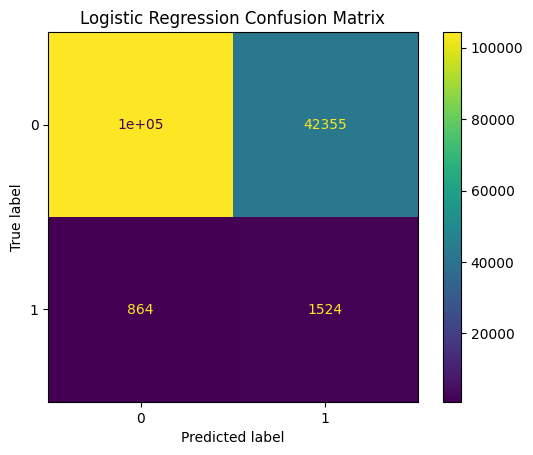

In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#logreg
ConfusionMatrixDisplay(confusion_matrix(y_test, log_preds)).plot()
plt.grid(False)
plt.title("Logistic Regression Confusion Matrix")

cm = confusion_matrix(y_test, log_preds)
# Create labeled DataFrame
cm_df = pd.DataFrame(cm,
                     index=['Actual Negative (0)', 'Actual Positive (1)'],
                     columns=['Predicted Negative (0)', 'Predicted Positive (1)'])
cm_df

,Predicted Negative (0),Predicted Positive (1)
Actual Negative (0),146707,28
Actual Positive (1),2013,375


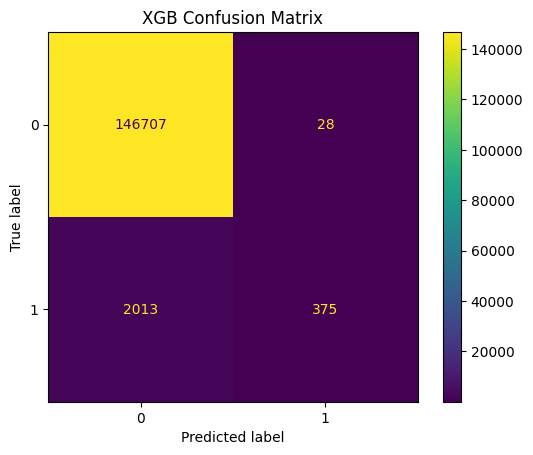

In [107]:
#xgb
ConfusionMatrixDisplay(confusion_matrix(y_test, xgb_preds)).plot()
plt.grid(False)
plt.title("XGB Confusion Matrix")

cm = confusion_matrix(y_test, xgb_preds)
# Create labeled DataFrame
cm_df = pd.DataFrame(cm,
                     index=['Actual Negative (0)', 'Actual Positive (1)'],
                     columns=['Predicted Negative (0)', 'Predicted Positive (1)'])
cm_df

,Predicted Negative (0),Predicted Positive (1)
Actual Negative (0),104932,41803
Actual Positive (1),885,1503


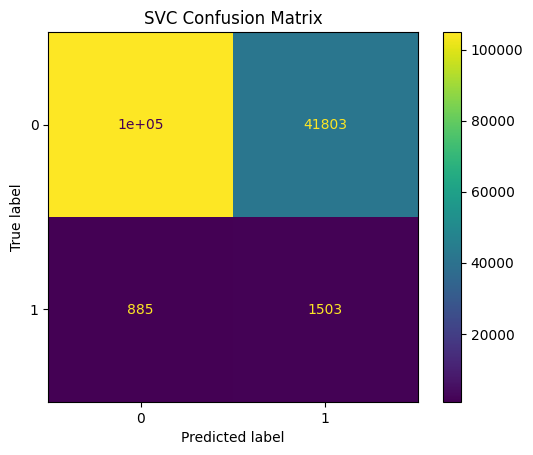

In [108]:
#svc
ConfusionMatrixDisplay(confusion_matrix(y_test, svc_preds)).plot()
plt.grid(False)
plt.title("SVC Confusion Matrix")

cm = confusion_matrix(y_test, svc_preds)

# Create labeled DataFrame
cm_df = pd.DataFrame(cm,
                     index=['Actual Negative (0)', 'Actual Positive (1)'],
                     columns=['Predicted Negative (0)', 'Predicted Positive (1)'])
cm_df

# **Model Selection Summary**

In this project, we evaluated multiple classification models — **Logistic Regression**, **Support Vector Classifier (SVC)**, and **XGBoost** — to detect fraudulent transactions in a highly imbalanced dataset. The objective was to select the model that offers the best trade-off between **precision** and **recall**, focusing on minimizing both false positives and false negatives — key metrics in fraud detection systems.

---

### ✅ XGBoost: The Best Performing Model

After comprehensive evaluation, **XGBoost emerged as the top-performing model**, demonstrating superior performance in the following areas:

- **F1 Score**: `0.33` — best balance between precision and recall.
- **Precision**: `0.63` — most predictions flagged as fraud are actually correct.
- **False Positives**: `28` — dramatically fewer than other models.
- **Recall**: `0.22` — captures a good portion of actual fraud cases.
- **Training Time**: `~115 seconds` — efficient and practical for deployment.

---

### ⚖️ Why Not Logistic Regression or SVC?

While both **Logistic Regression** and **SVC** achieved similar recall scores (`~0.16–0.18`), they suffered from:

- **Low precision** (`~0.13–0.15`), resulting in many false alarms.
- **Extremely high false positives** (40,000+), making them impractical for production.
- **Longer training time** (Logistic Regression took over 1300 seconds).

---

### 🏁 Conclusion

Given the dataset imbalance and the critical business requirement to detect fraud accurately and efficiently:

> ✅ **XGBoost** is the optimal choice for deployment.

It offers the **best balance of performance and interpretability**, drastically reduces false positives, and is computationally efficient — all of which are essential qualities for a real-world fraud detection model.
